In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import mdtraj as md
import barnaba as bb
from scipy.signal import find_peaks
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os


indir = "../../REST2_dynamics/UUCG/300K"
outdir = "../output/UUCG/300K/ermsd"
os.system("mkdir -p %s"%outdir)

reference = "%s/reference_structures/UUCG-native.pdb"%indir  #usually is the native structure.
topol = "%s/reference_structures/UUCG-native.pdb"%indir  #doesn't have to be the same as reference.
traj = "%s/trajectories/traj_all_ffs-comb_ensembles.xtc"%indir  #needs to have the same number of atoms as the reference pdb.

# Custom functions

In [2]:
#Function to create a custom cmap based on tab20 to be used throughout.
def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

# Calculate eRMSD

In [3]:
# align trajectory to gro (behaves better) of native structure with the same sequence

#Calculate eRMSD of traj frames from native structure. eRMSD is a dimensionless number.
#Remember to remove PBC conditions before performing the analysis.
ermsd = bb.ermsd(reference, traj, topology=topol)
stri = "".join([ "%14e \n" % (dd) for dd in ermsd])

#Write the values.
fh = open("%s/ermsd_supertraj_to_ref.dat" % outdir, 'w')
fh.write(stri)
fh.close()

# Loaded reference ../REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 
# Loaded target ../REST2_dynamics/UUCG/300K/trajectories/traj_all_ffs-comb_ensembles.xtc 


# Plot the results

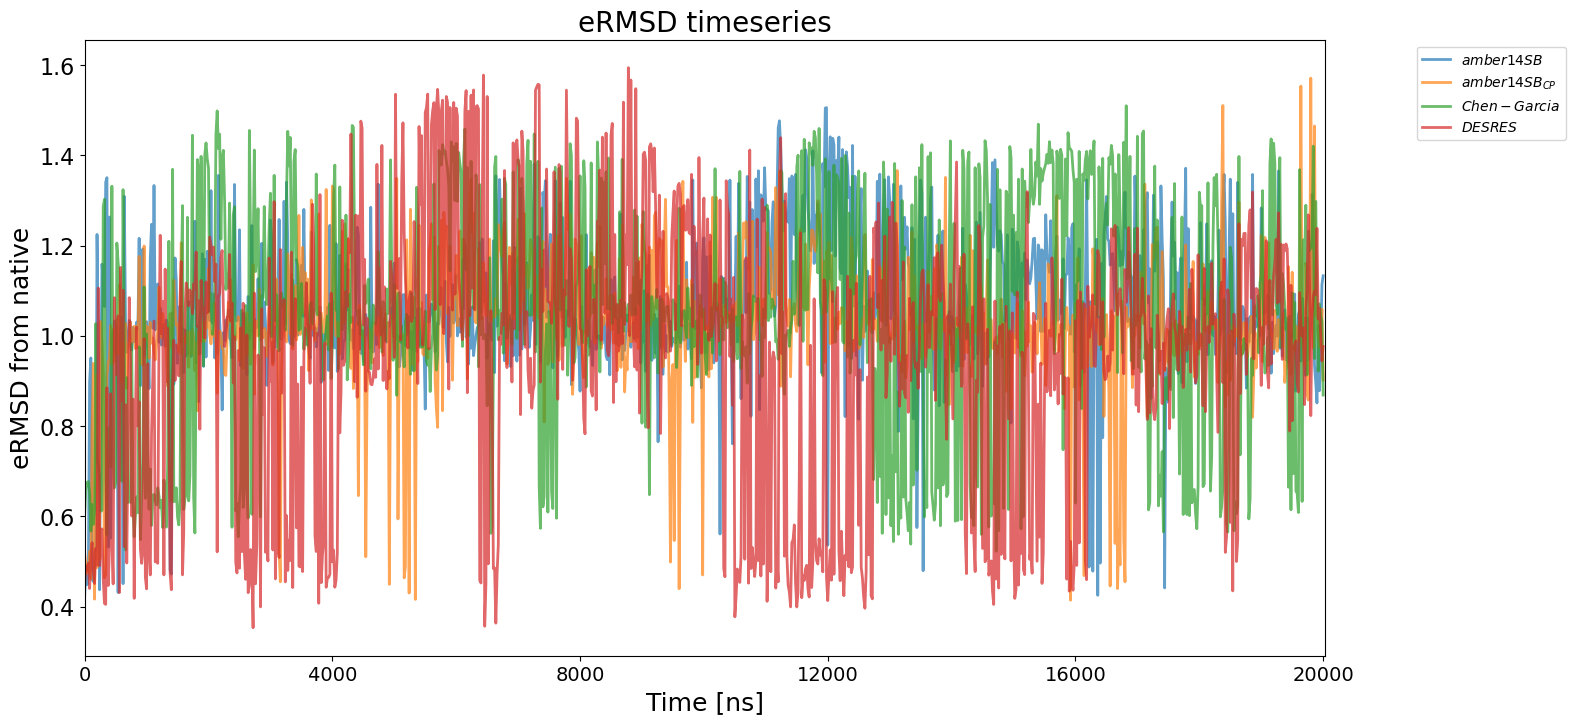

In [4]:
# Plot time series.

ffs = ["amber14SB", "amber14SB_{CP}", "Chen-Garcia", "DESRES"]
runs = ["ff14", "ff14_CP", "CG", "desres"]

cat_cmap = categorical_cmap(len(ffs), 1, "tab10")


plt.figure(figsize=(16, 8))

step=100
nblocks=len(ffs) #THE NUMBER OF SUB-TRAJECTORIES
x = np.arange(0,np.floor(len(ermsd)/nblocks),step)

for i in range(nblocks):
    y = ermsd[int(np.floor(len(ermsd)/nblocks))*i:int(np.floor(len(ermsd)/nblocks))*(i+1):step]
    plt.plot(x, y, label=r"$%s$"%(ffs[i]), lw=2, alpha=0.7, color=cat_cmap(i))


plt.legend(loc='upper right', bbox_to_anchor=(1.2,1))
plt.xlim(xmin=-10, xmax=len(x)*step+10)
ticks, labels = plt.xticks()
plt.xticks(ticks[1:-1], [int(i)//step*20 for i in ticks[1:-1]], fontsize=14)
plt.yticks(fontsize=16)
plt.xlabel("Time [ns]", fontsize=18)
plt.ylabel("eRMSD from native", fontsize=18)
plt.title("eRMSD timeseries", fontsize=20)
plt.savefig("%s/eRMSD-timeseries.png" %(outdir), dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

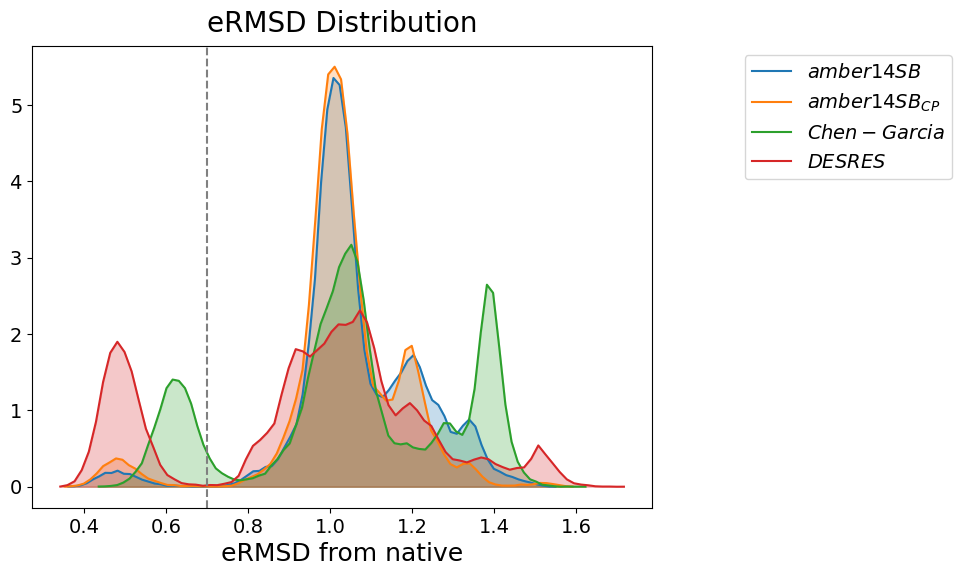

In [5]:
#plot hist with blocks
plt.figure(figsize=(8,6))
bins=80

blocksize=int(ermsd.shape[0]/nblocks)
for j in range(nblocks):
    start=j*(blocksize)
    end= start+blocksize
    hh, ee = np.histogram(ermsd[start:end],bins=bins,density=True)
    plt.plot(0.5*(ee[1:]+ee[:-1]),hh,label=r"$%s$"%(ffs[j]), color=cat_cmap(j))
    plt.fill_between(0.5*(ee[1:]+ee[:-1]),hh, alpha=0.25, color=cat_cmap(j))

plt.axvline(0.7, ls="--", c="grey") #indicates similarity threshold.
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1), fontsize=14)
plt.xlabel("eRMSD from native", fontsize=18)
plt.title("eRMSD Distribution", fontsize=20, pad=10)
plt.xticks(size=14)
plt.yticks(size=14)
plt.savefig("%s/eRMSD-histo_w_blocks-w_0.7line.png" %(outdir), dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()